# Benchmarking Geral

* `Objetivo:` Avaliar a classificação de séries temporais usando 3 diferentes abordagens, incluindo nossa hipótese, de codificar séries temporais através do Gráfico de Recorrência;

* `Cenário Comparativo`: 
    - <u>Dados:</u> Considerando os dados estabelecidos no *Benchmarking 1*;
        * *Detalhes:* Base REDD, baixa Frequência, Resid. 3, com 9 aparelhos (4k amostras treino/4k teste);
        * *Amostras:* Blocos de 1 minuto e 30 segundos (90 segundos - 30 'chunks', dado delay *3s*) de cada medição;
    
    - <u>Atributos *(Feature Space)*:</u> representação vetorial das amostras;
        1. **Abordagem Estatística (Benchmarking 1)**: Média, Desvio Padrão, Máximo, Energia Total, Hora do Dia e Temperatura Ambiente (zerado, neste caso, pois não foi disponibilizado pelos autores); 
        2. **Abordagem GAF (Benchmarking 2)**: Representação visual da amostra, através do algoritmo *Wang and Oates’[20]/Gramian Angular Field Matrices (GAF)*, e subsequente *embedding* com uma Rede Neural com arquitetura VGG16;
        3. **Abordagem RP (Hipótese 1)**: Nossa hipótese, converter a amostra em uma representação visual com a técnica de Gráfico de Recorrência (RP, do inglês *Recurrence Plot*); seguindo o *Benchmarking 2*, é realizado o *embedding* da imagem resultante com uma Rede Neural com arquitetura VGG16.
        4. **Abordagem RP+RQA (Hipótese 2)**: A partir do RP, extrair métricas de RQA, as quais alimentarão o classificador de cargas.
        
    - <u>Método de Classificação:</u> Rede Neural Multi-camadas (MLP, sem hiperparametrização - pacote [Scikit-lean](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier));
    
    - <u>Métrica(s):</u> uma vez que o problema irá ser tratado como classificação multi-rótulo, irão ser adotadas as seguintes métricas (via pacote [Scikit-learn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html))
        * Classificaton Report, contendo:
            * Acurácia;
            * Precisão;
            * Recall;
            * F1-score;
            * Hamming Loss;
            * Suporte (0/1);
        * Matriz de confusão.

# Configurando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys, cv2
from math import *
from pprint import pprint
from time import time
from tqdm import tqdm_notebook, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from keras_tqdm import TQDMNotebookCallback
tqdm_callback = TQDMNotebookCallback()
setattr(tqdm_callback,'on_train_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_train_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_begin', lambda x:None)
setattr(tqdm_callback,'on_test_end', lambda x:None)

import random as rn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import *

from pyts.image import RecurrencePlot, GramianAngularField

DATASET_PATH = 'datasets/REDD/phd'
SEED = 33
TEST_SIZE = 0.25

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# BENCHMARKING1_RESOURCES_PATH = 'benchmarkings/cs446 project-electric-load-identification-using-machine-learning/'
# BENCHMARKING2_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'
HYPOTHESIS_RESOURCES_PATH = 'datasets/hipotese1-recurrenceplot-vggembedding/'

# sys.path.append(os.path.join(BENCHMARKING1_RESOURCES_PATH, ''))
# sys.path.append(os.path.join(BENCHMARKING2_RESOURCES_PATH, ''))
# sys.path.append(os.path.join(HYPOTHESIS_RESOURCES_PATH, ''))

# from serie2QMlib import *

import warnings
warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


In [2]:
tf.__version__

'2.0.0'

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
# tf.debugging.set_log_device_placement(False)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            

#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carregando os dados

In [6]:
# dataset_size = 404107

# fileprefix = 'channel_'

# # devices to be used in training and testing
# use_idx = np.array([3,4,6,7,10,11,13,17,19])

# label_columns_idx = ["APLIANCE_{}".format(i) for i in use_idx]

# appliance_labels = [
#     "Electronics", 
#     "Refrigerator", 
#     "Dishwasher",
#     "Furnace", 
#     "Washer Dryer 1", 
#     "Washer Dryer 2", 
#     "Microwave", 
#     "Bathroom GFI",
#     "Kitchen Outlets"
# ]

# # Select some appliances for paper
# valid_appliances = [
#     "Refrigerator", "Dishwasher", "Furnace", "Wash Dryer 1", "Microwave"
# ]
# valid_appliances_index = [
#     1, 2, 3, 4, 6
# ]
# #np.array(appliance_labels)[valid_appliances_index])

In [7]:
# For the development of the proposed system based on a Neural Convolutional Network to identify the equipment, 
# in an initial phase, 6 equipment were chosen: 
# microwave, oven, dishwasher, air conditioning, washer / dryer and refrigerator. 
# The chosen equipment can be considered the most energy consuming in a residence. According to Batra [16], it is 
# necessary to prioritize the identification of equipment with higher energy consumption in the residences, since 
# these devices contribute with the most significant characteristics in the aggregate load, and the other appliances, 
# with lower consumption, can only be considered as noise in the load total aggregate.

appliances = [
    {"channel": 1, "name": "mains 1"},
    {"channel": 2, "name": "mains 2"},
    {"channel": 7, "name": "refrigerator"},
    {"channel": 9, "name": "dishwasher"},
    {"channel": 13, "name": "washer dryer 1"},
    {"channel": 14, "name": "washer dryer 2"},
    {"channel": 16, "name": "microwave"}
]

valid_appliances = appliances
## TODO: Adaptative length ny appliance...
# Microwave 191
# Dishwasher 588
# Refrigerator 2401

# Reading pre-processed data
mains = []
labels_power = []
labels_binary = []
valid_appliances = []

for a in tqdm(appliances):
    
    if a["channel"] in [1, 2]: # Mains
        file_chunks = glob(os.path.join(DATASET_PATH, "{}-*.npy".format(a["channel"])))[0]
        mains.append(np.load(file_chunks))
    else:
        #file_total = glob(os.path.join(DATASET_PATH, "{}-*total.npy".format(a["channel"])))[0]
        #labels_power.append(np.load(file_total))

        file_binary = glob(os.path.join(DATASET_PATH, "{}-*_binary.npy".format(a["channel"])))[0]
        labels_binary.append(np.load(file_binary))
        
        valid_appliances.append(a["name"])

mains = np.array(mains)
mains_idx = 0
#labels_power = np.array(labels_power).T
labels_binary = np.array(labels_binary).T

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 48.07it/s]


In [8]:
# X_train_multilabel, X_test_multilabel, y_train_multilabel, y_test_multilabel = train_test_split(
#     mains_1, labels_binary,
#     #stratify = labels_binary,
#     random_state=SEED, test_size=0.1, shuffle=True
# )

# Funções

In [9]:
def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show();
    return

def classification_report(y_test, y_pred, labels = None):
    
    final_performance = []
    
    for i in range(y_test.shape[1]):
    
        test = y_test[:, i]
        predicted = y_pred[:, i]
        #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
        acc = accuracy_score(test, predicted)
        prec = precision_score(test, predicted)
        rec = recall_score(test, predicted)    
        f1 = f1_score(test, predicted)
        f1m = f1_score(test, predicted, average='macro')
        hl = hamming_loss(test, predicted)   
        auc_ = roc_auc_score(test, predicted)
        y_i = y_test[:, i]
        supp_0 = y_i[y_i==0].shape[0]
        supp_1 = y_i[y_i==1].shape[0]

        final_performance.append([
            labels[i] if labels is not None else label_columns_idx[i], 
            round(acc*100, 2), 
            round(prec*100, 2), 
            round(rec*100, 2), 
            round(f1*100, 2), 
            round(f1m*100, 2),
            round(hl, 2),
            round(auc_, 2),
            supp_0,
            supp_1
        ])

    print("CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):")
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

    print("")
    print("OVERALL AVERAGE PERFORMANCE:")
    display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON), BY APPLIANCE:")
    
    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, a in enumerate(labels):
        print("")
        print(" - {}:".format(a))
        print(cms[i])
    #print(, labels= appliance_labels)


    
def classification_report_appliance(y_test, y_pred, label = None):
    
    final_performance = []
    
    test = y_test
    predicted = y_pred
    #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)    
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    hl = hamming_loss(test, predicted)   
    auc_ = roc_auc_score(test, predicted)
    y_i = y_test
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]

    final_performance = [[
        label, 
        round(acc*100, 2), 
        round(prec*100, 2), 
        round(rec*100, 2), 
        round(f1*100, 2), 
        round(f1m*100, 2),
        round(hl, 2),
        round(auc_, 2),
        supp_0,
        supp_1
    ]]

    print("CLASSIFIER PERFORMANCE {} MODEL:".format(label.upper()))
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

#     print("")
#     print("OVERALL AVERAGE PERFORMANCE:")
#     display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON):")
    
    cms = confusion_matrix(y_test, y_pred)
    for i, a in enumerate([label]):
        print("")
        print(" - {}:".format(a))
        print(cms)

In [10]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
def calculate_metrics(estimator, X_test, y_test):
    y_pred = np.array(estimator.model.predict(X_test).round()) # TODO: corrigir '.model' (https://github.com/keras-team/keras/issues/9331)
    return (
        accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred, average='macro'), 
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='micro'),
        f1_score(y_test, y_pred, average='macro')
    )

def global_scorer(estimator, X_test, y_test):
    acc, prec, rec, f1_micro, f1m = calculate_metrics(estimator, X_test, y_test)
    return acc, prec, rec, f1_micro, f1m

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    acc, prec, rec, f1_micro, f1m = global_scorer(model, X_test, y_test)
    return [acc, prec, rec, f1_micro, f1m]

#label_encoder = LabelEncoder()

kfold = StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state= 33
)

# Deep Learning

## Funções Auxiliares

In [12]:
import shutil
from tensorflow.keras import optimizers

class ImageProcessing():
    def __init__(self, image_size_px = 128, Y = None):
        self.image_size_px = image_size_px
        
    def fit(self, images, Y = None, mode = "train"):
        return self

    def transform(self, images, Y = None, mode = 'train'):
        processed_images = []
        try:
#             for idx, image in tqdm_notebook(enumerate(images), total=len(images)):
#                 img = np.stack((image,) * 3, -1)
#                 processed_images.append(img/255)
            if os.path.isdir(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp")):        
                shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            os.makedirs(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
                
            for idx, image in tqdm_notebook(enumerate(images)):
#                 labels = Y[idx, :].astype('str').tolist()
#                 labels_str = ''.join(labels)
                image_path = os.path.join( 
                        HYPOTHESIS_RESOURCES_PATH, "temp",
                        "{}_{}_color.png".format(idx, mode) 
                    )
                imsave(
                    image_path, 
                    arr=image
                )
                # Reading image in 3channel RGB mode
                img = keras_image.load_img( image_path, target_size=(self.image_size_px, self.image_size_px ,3))
                img = keras_image.img_to_array(img)
                img = img/255                
                #img = MinMaxScaler(feature_range=(-1, 1)).fit_transform(img.reshape(1,-1)).reshape(img.shape)
                processed_images.append(img)
            
            shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            
        except Exception as err:
            print('ImageProcessing.transform(): {}'.format(err))
            
        return np.array(processed_images)
        #return processed_images

    def fit_transform(self, images, Y = None, mode = 'train'):
        self.fit(images)
        return self.transform(images, Y, mode)

## Arquiteturas de CNN

In [13]:
#from keras.callbacks import TensorBoard
from datetime import datetime

log_dir =  log_dir = os.path.join(
    "logs",
    "fit",
    datetime.now().strftime("%Y%m%d-%H%M%S"),
)#"./logs/{}".format(time())
tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#################################### MODELOS 
def dcnn_multilabel(output_layer_length = len(valid_appliances)):
    model = Sequential()

#     model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_layer_length, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
    
    return model

# For training of the CNN a fixed size window as input layer is required. In the
# experiments 28×28, 56×56 and 64×64 pixel input, depend on the data, are used. Both layers contain 32 feature
# maps with 3×3 convolution (32×3×3), MaxPooling of size 2×2 and Dropout = 0.25. The fully connected neural
# layer contains 128 hidden neurons and c output neurons with Dropout = 0.5.
def dcnn_appliance(input_shape_ = (128,128,3), loss_function = 'binary_crossentropy'):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=[loss_function], metrics=['accuracy', f1])
    
    return model

def vgg_multilabel():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = train_rp_images[0].shape
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(len(valid_appliances), activation='softmax')(x) #final layer with softmax activation
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(
        optimizer=optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy', f1]
    )
    
    return model

def vgg_appliance():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = (128, 128, 3)
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    
#     #x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#     x=Dense(1024,activation='relu')(x) #dense layer 2
#     x=Dense(512,activation='relu')(x) #dense layer 3
#     #output_layer = Dense(2, activation='softmax')(x) #final layer with softmax activation
    
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    
    return model

def tiled_cnn_multilabel( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(len(valid_appliances), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
    
    return model

def tiled_cnn_appliance( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    
    return model

In [14]:
EPOCHS = 1000
BATCH_SIZE = 256

## Imagens GAF

In [15]:
if not os.path.isfile( os.path.join(DATASET_PATH, "gaf_images.npy") ):
    
    print("Generating GAF images from data...")
    gaf_pipeline = Pipeline([
        ('gramianangularfield', GramianAngularField()),
        ('imageprocessing', ImageProcessing())
    ])
    series_images = gaf_pipeline.fit_transform(mains[mains_idx,:,:], imageprocessing__mode = "_")
    np.save(os.path.join(DATASET_PATH, "gaf_images.npy"), series_images)
    
else:
    print("Loading GAF images...")
    series_images = np.load(os.path.join(DATASET_PATH, "gaf_images.npy"))

Loading GAF images...


In [16]:
# X_train, X_test, y_train, y_test = train_test_split(
#     series_images, labels_binary,
#     #stratify = labels_binary,
#     random_state=SEED, test_size=TEST_SIZE, shuffle=True
# )

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("---")
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

# del series_images

### Classificador Multilabel

In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = dcnn_multilabel()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

Training GAF multilabel model...
Train on 38704 samples, validate on 4301 samples
Epoch 1/100


In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = tiled_cnn_multilabel()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1 = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1 = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### Classificadores Especialistas (Binários)


---> Splitting `{}` data (train/test)...
---> Training the `refrigerator` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 34s - loss: 0.4777 - accuracy: 0.8159 - f1: 0.8982 - val_loss: 0.4839 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 2/1000
32253/32253 - 22s - loss: 0.4522 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4915 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 3/1000
32253/32253 - 21s - loss: 0.4515 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4819 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 4/1000
32253/32253 - 21s - loss: 0.4502 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4763 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 5/1000
32253/32253 - 21s - loss: 0.4504 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4854 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 6/1000
32253/32253 - 21s - loss: 0.4489 - accuracy: 0.8168 - f1: 0.8990 - val_loss: 0.4710 - val_accuracy: 0.8168 - val_f1: 0.8990
Epoch 7/1000
32253/32253 - 21s - loss: 0.44

Epoch 60/1000
32253/32253 - 20s - loss: 0.3657 - accuracy: 0.8373 - f1: 0.9090 - val_loss: 0.7553 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 61/1000
32253/32253 - 20s - loss: 0.3665 - accuracy: 0.8357 - f1: 0.9081 - val_loss: 0.7620 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 62/1000
32253/32253 - 20s - loss: 0.3671 - accuracy: 0.8366 - f1: 0.9085 - val_loss: 0.7610 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 63/1000
32253/32253 - 20s - loss: 0.3664 - accuracy: 0.8366 - f1: 0.9086 - val_loss: 0.7695 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 64/1000
32253/32253 - 20s - loss: 0.3651 - accuracy: 0.8372 - f1: 0.9090 - val_loss: 0.7817 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 65/1000
32253/32253 - 20s - loss: 0.3660 - accuracy: 0.8368 - f1: 0.9087 - val_loss: 0.7726 - val_accuracy: 0.8116 - val_f1: 0.8957
Epoch 66/1000
32253/32253 - 20s - loss: 0.3652 - accuracy: 0.8378 - f1: 0.9092 - val_loss: 0.8414 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 67/1000
32253/32253 - 20s - 

Epoch 120/1000
32253/32253 - 20s - loss: 0.3590 - accuracy: 0.8394 - f1: 0.9102 - val_loss: 1.0950 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 121/1000
32253/32253 - 20s - loss: 0.3607 - accuracy: 0.8390 - f1: 0.9099 - val_loss: 0.9960 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 122/1000
32253/32253 - 20s - loss: 0.3578 - accuracy: 0.8400 - f1: 0.9105 - val_loss: 1.0406 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 123/1000
32253/32253 - 20s - loss: 0.3587 - accuracy: 0.8395 - f1: 0.9102 - val_loss: 0.9852 - val_accuracy: 0.8124 - val_f1: 0.8963
Epoch 124/1000
32253/32253 - 20s - loss: 0.3587 - accuracy: 0.8398 - f1: 0.9104 - val_loss: 1.0093 - val_accuracy: 0.8140 - val_f1: 0.8972
Epoch 125/1000
32253/32253 - 20s - loss: 0.3573 - accuracy: 0.8402 - f1: 0.9107 - val_loss: 0.9810 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 126/1000
32253/32253 - 20s - loss: 0.3590 - accuracy: 0.8397 - f1: 0.9103 - val_loss: 0.9954 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 127/1000
32253/32253 

Epoch 179/1000
32253/32253 - 20s - loss: 0.3562 - accuracy: 0.8404 - f1: 0.9107 - val_loss: 1.1271 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 180/1000
32253/32253 - 20s - loss: 0.3561 - accuracy: 0.8407 - f1: 0.9109 - val_loss: 1.1749 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 181/1000
32253/32253 - 20s - loss: 0.3563 - accuracy: 0.8404 - f1: 0.9108 - val_loss: 1.1642 - val_accuracy: 0.8107 - val_f1: 0.8953
Epoch 182/1000
32253/32253 - 20s - loss: 0.3580 - accuracy: 0.8402 - f1: 0.9106 - val_loss: 1.0717 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 183/1000
32253/32253 - 20s - loss: 0.3572 - accuracy: 0.8401 - f1: 0.9106 - val_loss: 1.1484 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 184/1000
32253/32253 - 20s - loss: 0.3571 - accuracy: 0.8396 - f1: 0.9103 - val_loss: 1.1631 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 185/1000
32253/32253 - 20s - loss: 0.3566 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.1594 - val_accuracy: 0.8144 - val_f1: 0.8975
Epoch 186/1000
32253/32253 

Epoch 238/1000
32253/32253 - 20s - loss: 0.3552 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.2009 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 239/1000
32253/32253 - 20s - loss: 0.3561 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.1845 - val_accuracy: 0.8121 - val_f1: 0.8961
Epoch 240/1000
32253/32253 - 20s - loss: 0.3565 - accuracy: 0.8404 - f1: 0.9108 - val_loss: 1.2357 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 241/1000
32253/32253 - 20s - loss: 0.3566 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.2161 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 242/1000
32253/32253 - 20s - loss: 0.3570 - accuracy: 0.8404 - f1: 0.9107 - val_loss: 1.2937 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 243/1000
32253/32253 - 20s - loss: 0.3545 - accuracy: 0.8409 - f1: 0.9111 - val_loss: 1.2227 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 244/1000
32253/32253 - 20s - loss: 0.3552 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.2774 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 245/1000
32253/32253 

Epoch 297/1000
32253/32253 - 20s - loss: 0.3555 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.1513 - val_accuracy: 0.8124 - val_f1: 0.8963
Epoch 298/1000
32253/32253 - 20s - loss: 0.3555 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.2412 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 299/1000
32253/32253 - 20s - loss: 0.3544 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.2811 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 300/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.2705 - val_accuracy: 0.8129 - val_f1: 0.8965
Epoch 301/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3124 - val_accuracy: 0.8140 - val_f1: 0.8972
Epoch 302/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3178 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 303/1000
32253/32253 - 20s - loss: 0.3550 - accuracy: 0.8409 - f1: 0.9110 - val_loss: 1.2745 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 304/1000
32253/32253 

Epoch 356/1000
32253/32253 - 20s - loss: 0.3547 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.3067 - val_accuracy: 0.8126 - val_f1: 0.8964
Epoch 357/1000
32253/32253 - 20s - loss: 0.3565 - accuracy: 0.8405 - f1: 0.9108 - val_loss: 1.1440 - val_accuracy: 0.8121 - val_f1: 0.8961
Epoch 358/1000
32253/32253 - 20s - loss: 0.3559 - accuracy: 0.8404 - f1: 0.9107 - val_loss: 1.2803 - val_accuracy: 0.8133 - val_f1: 0.8969
Epoch 359/1000
32253/32253 - 20s - loss: 0.3545 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.2471 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 360/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.4485 - val_accuracy: 0.8140 - val_f1: 0.8972
Epoch 361/1000
32253/32253 - 20s - loss: 0.3563 - accuracy: 0.8406 - f1: 0.9109 - val_loss: 1.1856 - val_accuracy: 0.8120 - val_f1: 0.8960
Epoch 362/1000
32253/32253 - 20s - loss: 0.3546 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.2681 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 363/1000
32253/32253 

Epoch 415/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3235 - val_accuracy: 0.8122 - val_f1: 0.8962
Epoch 416/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.4064 - val_accuracy: 0.8125 - val_f1: 0.8964
Epoch 417/1000
32253/32253 - 20s - loss: 0.3550 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.2590 - val_accuracy: 0.8128 - val_f1: 0.8965
Epoch 418/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.3070 - val_accuracy: 0.8127 - val_f1: 0.8965
Epoch 419/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.3351 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 420/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8412 - f1: 0.9113 - val_loss: 1.3015 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 421/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2997 - val_accuracy: 0.8118 - val_f1: 0.8959
Epoch 422/1000
32253/32253 

Epoch 474/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.3346 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 475/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2750 - val_accuracy: 0.8122 - val_f1: 0.8962
Epoch 476/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.3373 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 477/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3839 - val_accuracy: 0.8138 - val_f1: 0.8971
Epoch 478/1000
32253/32253 - 20s - loss: 0.3544 - accuracy: 0.8409 - f1: 0.9111 - val_loss: 1.3474 - val_accuracy: 0.8133 - val_f1: 0.8968
Epoch 479/1000
32253/32253 - 20s - loss: 0.3540 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.3665 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 480/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4039 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 481/1000
32253/32253 

Epoch 533/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.4298 - val_accuracy: 0.8129 - val_f1: 0.8966
Epoch 534/1000
32253/32253 - 20s - loss: 0.3531 - accuracy: 0.8417 - f1: 0.9114 - val_loss: 1.4170 - val_accuracy: 0.8129 - val_f1: 0.8966
Epoch 535/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.5814 - val_accuracy: 0.8148 - val_f1: 0.8978
Epoch 536/1000
32253/32253 - 20s - loss: 0.3549 - accuracy: 0.8408 - f1: 0.9110 - val_loss: 1.2943 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 537/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.3197 - val_accuracy: 0.8126 - val_f1: 0.8964
Epoch 538/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.4907 - val_accuracy: 0.8141 - val_f1: 0.8973
Epoch 539/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.5188 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 540/1000
32253/32253 

Epoch 592/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.4794 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 593/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5693 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 594/1000
32253/32253 - 20s - loss: 0.3541 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4234 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 595/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.2770 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 596/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4133 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 597/1000
32253/32253 - 20s - loss: 0.3529 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5206 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 598/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3311 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 599/1000
32253/32253 

Epoch 651/1000
32253/32253 - 20s - loss: 0.3543 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.4298 - val_accuracy: 0.8142 - val_f1: 0.8973
Epoch 652/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.6031 - val_accuracy: 0.8145 - val_f1: 0.8975
Epoch 653/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5166 - val_accuracy: 0.8135 - val_f1: 0.8969
Epoch 654/1000
32253/32253 - 20s - loss: 0.3530 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.4869 - val_accuracy: 0.8128 - val_f1: 0.8965
Epoch 655/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4932 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 656/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.3479 - val_accuracy: 0.8118 - val_f1: 0.8959
Epoch 657/1000
32253/32253 - 20s - loss: 0.3540 - accuracy: 0.8411 - f1: 0.9111 - val_loss: 1.5098 - val_accuracy: 0.8142 - val_f1: 0.8973
Epoch 658/1000
32253/32253 

Epoch 710/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.5222 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 711/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8411 - f1: 0.9112 - val_loss: 1.2496 - val_accuracy: 0.8123 - val_f1: 0.8962
Epoch 712/1000
32253/32253 - 20s - loss: 0.3535 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2200 - val_accuracy: 0.8117 - val_f1: 0.8958
Epoch 713/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.3840 - val_accuracy: 0.8132 - val_f1: 0.8967
Epoch 714/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3769 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 715/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8414 - f1: 0.9113 - val_loss: 1.2667 - val_accuracy: 0.8122 - val_f1: 0.8962
Epoch 716/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.3751 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 717/1000
32253/32253 

Epoch 769/1000
32253/32253 - 20s - loss: 0.3545 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.3657 - val_accuracy: 0.8130 - val_f1: 0.8966
Epoch 770/1000
32253/32253 - 20s - loss: 0.3527 - accuracy: 0.8417 - f1: 0.9115 - val_loss: 1.4410 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 771/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5554 - val_accuracy: 0.8142 - val_f1: 0.8974
Epoch 772/1000
32253/32253 - 20s - loss: 0.3538 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.2675 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 773/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8418 - f1: 0.9116 - val_loss: 1.3949 - val_accuracy: 0.8125 - val_f1: 0.8963
Epoch 774/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8418 - f1: 0.9115 - val_loss: 1.4143 - val_accuracy: 0.8126 - val_f1: 0.8964
Epoch 775/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.3095 - val_accuracy: 0.8134 - val_f1: 0.8969
Epoch 776/1000
32253/32253 

Epoch 828/1000
32253/32253 - 20s - loss: 0.3527 - accuracy: 0.8418 - f1: 0.9116 - val_loss: 1.4960 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 829/1000
32253/32253 - 20s - loss: 0.3533 - accuracy: 0.8413 - f1: 0.9112 - val_loss: 1.3273 - val_accuracy: 0.8144 - val_f1: 0.8974
Epoch 830/1000
32253/32253 - 20s - loss: 0.3530 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.3374 - val_accuracy: 0.8117 - val_f1: 0.8958
Epoch 831/1000
32253/32253 - 20s - loss: 0.3537 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.5388 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 832/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8419 - f1: 0.9116 - val_loss: 1.6530 - val_accuracy: 0.8148 - val_f1: 0.8978
Epoch 833/1000
32253/32253 - 20s - loss: 0.3531 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.7925 - val_accuracy: 0.8145 - val_f1: 0.8976
Epoch 834/1000
32253/32253 - 20s - loss: 0.3542 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.4438 - val_accuracy: 0.8135 - val_f1: 0.8969
Epoch 835/1000
32253/32253 

Epoch 887/1000
32253/32253 - 20s - loss: 0.3534 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5255 - val_accuracy: 0.8143 - val_f1: 0.8974
Epoch 888/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.5937 - val_accuracy: 0.8139 - val_f1: 0.8972
Epoch 889/1000
32253/32253 - 20s - loss: 0.3539 - accuracy: 0.8410 - f1: 0.9111 - val_loss: 1.4213 - val_accuracy: 0.8129 - val_f1: 0.8966
Epoch 890/1000
32253/32253 - 20s - loss: 0.3530 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.5758 - val_accuracy: 0.8146 - val_f1: 0.8976
Epoch 891/1000
32253/32253 - 20s - loss: 0.3536 - accuracy: 0.8412 - f1: 0.9112 - val_loss: 1.5760 - val_accuracy: 0.8137 - val_f1: 0.8971
Epoch 892/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8413 - f1: 0.9113 - val_loss: 1.4363 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 893/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8417 - f1: 0.9115 - val_loss: 1.5355 - val_accuracy: 0.8146 - val_f1: 0.8976
Epoch 894/1000
32253/32253 

Epoch 946/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8418 - f1: 0.9115 - val_loss: 1.4985 - val_accuracy: 0.8131 - val_f1: 0.8967
Epoch 947/1000
32253/32253 - 20s - loss: 0.3522 - accuracy: 0.8417 - f1: 0.9115 - val_loss: 1.5958 - val_accuracy: 0.8136 - val_f1: 0.8970
Epoch 948/1000
32253/32253 - 20s - loss: 0.3523 - accuracy: 0.8417 - f1: 0.9114 - val_loss: 1.5392 - val_accuracy: 0.8135 - val_f1: 0.8970
Epoch 949/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8415 - f1: 0.9113 - val_loss: 1.4920 - val_accuracy: 0.8132 - val_f1: 0.8968
Epoch 950/1000
32253/32253 - 20s - loss: 0.3524 - accuracy: 0.8418 - f1: 0.9115 - val_loss: 1.6430 - val_accuracy: 0.8144 - val_f1: 0.8975
Epoch 951/1000
32253/32253 - 20s - loss: 0.3532 - accuracy: 0.8416 - f1: 0.9114 - val_loss: 1.4863 - val_accuracy: 0.8139 - val_f1: 0.8972
Epoch 952/1000
32253/32253 - 20s - loss: 0.3528 - accuracy: 0.8415 - f1: 0.9114 - val_loss: 1.4865 - val_accuracy: 0.8139 - val_f1: 0.8972
Epoch 953/1000
32253/32253 

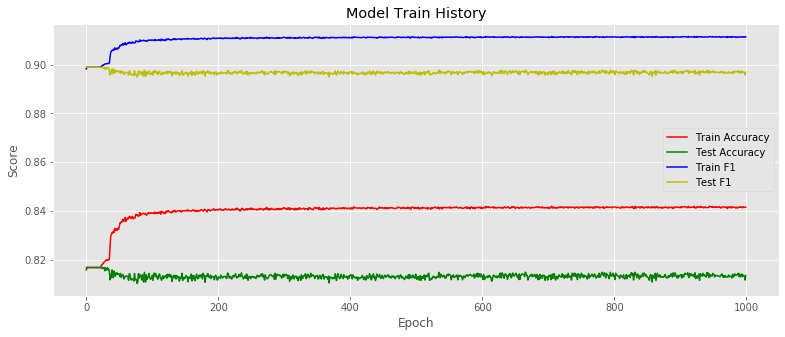

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,81.35,81.65,99.54,89.71,45.1,0.19,0.5,1970,8782



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[   5 1965]
 [  40 8742]]


---> Splitting `{}` data (train/test)...
---> Training the `dishwasher` model...

Train on 32253 samples, validate on 10752 samples
Epoch 1/1000
32253/32253 - 29s - loss: 0.4302 - accuracy: 0.8720 - f1: 0.9299 - val_loss: 0.4372 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 2/1000
32253/32253 - 21s - loss: 0.3793 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4208 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 3/1000
32253/32253 - 22s - loss: 0.3787 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4215 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 4/1000
32253/32253 - 22s - loss: 0.3790 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.3982 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 5/1000
32253/32253 - 21s - loss: 0.3782 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4072 - val_accuracy: 0.8762 - val_f1: 0.9339
Epoch 6/1000
32253/32253 - 21s - loss: 0.3791 - accuracy: 0.8762 - f1: 0.9339 - val_loss: 0.4051 - val_accur

Epoch 59/1000
32253/32253 - 20s - loss: 0.2564 - accuracy: 0.9174 - f1: 0.9546 - val_loss: 0.7692 - val_accuracy: 0.8710 - val_f1: 0.9307
Epoch 60/1000
32253/32253 - 20s - loss: 0.2552 - accuracy: 0.9170 - f1: 0.9544 - val_loss: 0.7307 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 61/1000
32253/32253 - 20s - loss: 0.2558 - accuracy: 0.9169 - f1: 0.9544 - val_loss: 0.7486 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 62/1000
32253/32253 - 20s - loss: 0.2571 - accuracy: 0.9169 - f1: 0.9544 - val_loss: 0.7439 - val_accuracy: 0.8674 - val_f1: 0.9285
Epoch 63/1000
32253/32253 - 20s - loss: 0.2549 - accuracy: 0.9177 - f1: 0.9549 - val_loss: 0.6929 - val_accuracy: 0.8663 - val_f1: 0.9278
Epoch 64/1000
32253/32253 - 20s - loss: 0.2561 - accuracy: 0.9175 - f1: 0.9547 - val_loss: 0.7394 - val_accuracy: 0.8686 - val_f1: 0.9292
Epoch 65/1000
32253/32253 - 20s - loss: 0.2542 - accuracy: 0.9179 - f1: 0.9549 - val_loss: 0.8008 - val_accuracy: 0.8715 - val_f1: 0.9310
Epoch 66/1000
32253/32253 - 20s - 

Epoch 119/1000
32253/32253 - 20s - loss: 0.2464 - accuracy: 0.9209 - f1: 0.9566 - val_loss: 0.8975 - val_accuracy: 0.8659 - val_f1: 0.9277
Epoch 120/1000
32253/32253 - 20s - loss: 0.2480 - accuracy: 0.9210 - f1: 0.9566 - val_loss: 0.9287 - val_accuracy: 0.8671 - val_f1: 0.9284
Epoch 121/1000
32253/32253 - 20s - loss: 0.2474 - accuracy: 0.9217 - f1: 0.9570 - val_loss: 0.9665 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 122/1000
32253/32253 - 20s - loss: 0.2462 - accuracy: 0.9209 - f1: 0.9566 - val_loss: 0.9353 - val_accuracy: 0.8678 - val_f1: 0.9288
Epoch 123/1000
32253/32253 - 20s - loss: 0.2465 - accuracy: 0.9210 - f1: 0.9566 - val_loss: 0.9292 - val_accuracy: 0.8679 - val_f1: 0.9288
Epoch 124/1000
32253/32253 - 20s - loss: 0.2469 - accuracy: 0.9208 - f1: 0.9565 - val_loss: 0.9486 - val_accuracy: 0.8669 - val_f1: 0.9283
Epoch 125/1000
32253/32253 - 20s - loss: 0.2491 - accuracy: 0.9209 - f1: 0.9566 - val_loss: 0.9267 - val_accuracy: 0.8672 - val_f1: 0.9285
Epoch 126/1000
32253/32253 

Epoch 178/1000
32253/32253 - 20s - loss: 0.2443 - accuracy: 0.9222 - f1: 0.9573 - val_loss: 0.9598 - val_accuracy: 0.8667 - val_f1: 0.9281
Epoch 179/1000
32253/32253 - 20s - loss: 0.2430 - accuracy: 0.9223 - f1: 0.9573 - val_loss: 0.9433 - val_accuracy: 0.8657 - val_f1: 0.9275
Epoch 180/1000
32253/32253 - 20s - loss: 0.2436 - accuracy: 0.9219 - f1: 0.9571 - val_loss: 1.0463 - val_accuracy: 0.8672 - val_f1: 0.9285
Epoch 181/1000
32253/32253 - 20s - loss: 0.2439 - accuracy: 0.9225 - f1: 0.9575 - val_loss: 1.0553 - val_accuracy: 0.8694 - val_f1: 0.9298
Epoch 182/1000
32253/32253 - 20s - loss: 0.2431 - accuracy: 0.9225 - f1: 0.9574 - val_loss: 1.0177 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 183/1000
32253/32253 - 20s - loss: 0.2440 - accuracy: 0.9222 - f1: 0.9573 - val_loss: 1.0141 - val_accuracy: 0.8685 - val_f1: 0.9292
Epoch 184/1000
32253/32253 - 20s - loss: 0.2440 - accuracy: 0.9221 - f1: 0.9572 - val_loss: 0.9847 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 185/1000
32253/32253 

Epoch 237/1000
32253/32253 - 20s - loss: 0.2423 - accuracy: 0.9233 - f1: 0.9579 - val_loss: 0.9723 - val_accuracy: 0.8664 - val_f1: 0.9279
Epoch 238/1000
32253/32253 - 20s - loss: 0.2419 - accuracy: 0.9232 - f1: 0.9578 - val_loss: 1.0368 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 239/1000
32253/32253 - 20s - loss: 0.2406 - accuracy: 0.9236 - f1: 0.9581 - val_loss: 1.0506 - val_accuracy: 0.8669 - val_f1: 0.9282
Epoch 240/1000
32253/32253 - 20s - loss: 0.2417 - accuracy: 0.9233 - f1: 0.9579 - val_loss: 1.0092 - val_accuracy: 0.8661 - val_f1: 0.9278
Epoch 241/1000
32253/32253 - 20s - loss: 0.2415 - accuracy: 0.9234 - f1: 0.9579 - val_loss: 1.0295 - val_accuracy: 0.8659 - val_f1: 0.9277
Epoch 242/1000
32253/32253 - 20s - loss: 0.2427 - accuracy: 0.9225 - f1: 0.9574 - val_loss: 1.0727 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 243/1000
32253/32253 - 20s - loss: 0.2404 - accuracy: 0.9234 - f1: 0.9580 - val_loss: 1.0247 - val_accuracy: 0.8656 - val_f1: 0.9275
Epoch 244/1000
32253/32253 

Epoch 296/1000
32253/32253 - 20s - loss: 0.2405 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.0994 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 297/1000
32253/32253 - 20s - loss: 0.2417 - accuracy: 0.9234 - f1: 0.9579 - val_loss: 1.1766 - val_accuracy: 0.8687 - val_f1: 0.9293
Epoch 298/1000
32253/32253 - 20s - loss: 0.2408 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.0841 - val_accuracy: 0.8680 - val_f1: 0.9289
Epoch 299/1000
32253/32253 - 20s - loss: 0.2415 - accuracy: 0.9234 - f1: 0.9580 - val_loss: 1.0465 - val_accuracy: 0.8665 - val_f1: 0.9281
Epoch 300/1000
32253/32253 - 20s - loss: 0.2416 - accuracy: 0.9233 - f1: 0.9579 - val_loss: 1.0557 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 301/1000
32253/32253 - 20s - loss: 0.2400 - accuracy: 0.9236 - f1: 0.9580 - val_loss: 1.0802 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 302/1000
32253/32253 - 20s - loss: 0.2419 - accuracy: 0.9236 - f1: 0.9581 - val_loss: 1.0344 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 303/1000
32253/32253 

Epoch 355/1000
32253/32253 - 20s - loss: 0.2403 - accuracy: 0.9238 - f1: 0.9581 - val_loss: 1.0957 - val_accuracy: 0.8674 - val_f1: 0.9285
Epoch 356/1000
32253/32253 - 20s - loss: 0.2401 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.0310 - val_accuracy: 0.8660 - val_f1: 0.9277
Epoch 357/1000
32253/32253 - 20s - loss: 0.2397 - accuracy: 0.9238 - f1: 0.9581 - val_loss: 1.1297 - val_accuracy: 0.8668 - val_f1: 0.9282
Epoch 358/1000
32253/32253 - 20s - loss: 0.2391 - accuracy: 0.9243 - f1: 0.9584 - val_loss: 1.0750 - val_accuracy: 0.8652 - val_f1: 0.9273
Epoch 359/1000
32253/32253 - 20s - loss: 0.2403 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.1810 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 360/1000
32253/32253 - 20s - loss: 0.2394 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.0902 - val_accuracy: 0.8655 - val_f1: 0.9275
Epoch 361/1000
32253/32253 - 20s - loss: 0.2398 - accuracy: 0.9237 - f1: 0.9581 - val_loss: 1.1599 - val_accuracy: 0.8683 - val_f1: 0.9291
Epoch 362/1000
32253/32253 

Epoch 414/1000
32253/32253 - 20s - loss: 0.2409 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.1562 - val_accuracy: 0.8687 - val_f1: 0.9293
Epoch 415/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9243 - f1: 0.9584 - val_loss: 1.1769 - val_accuracy: 0.8672 - val_f1: 0.9284
Epoch 416/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.1319 - val_accuracy: 0.8676 - val_f1: 0.9287
Epoch 417/1000
32253/32253 - 20s - loss: 0.2396 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.1027 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 418/1000
32253/32253 - 20s - loss: 0.2398 - accuracy: 0.9240 - f1: 0.9583 - val_loss: 1.2401 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 419/1000
32253/32253 - 20s - loss: 0.2419 - accuracy: 0.9237 - f1: 0.9581 - val_loss: 1.1791 - val_accuracy: 0.8679 - val_f1: 0.9290
Epoch 420/1000
32253/32253 - 20s - loss: 0.2379 - accuracy: 0.9245 - f1: 0.9586 - val_loss: 1.1370 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 421/1000
32253/32253 

Epoch 473/1000
32253/32253 - 20s - loss: 0.2382 - accuracy: 0.9245 - f1: 0.9585 - val_loss: 1.2188 - val_accuracy: 0.8700 - val_f1: 0.9301
Epoch 474/1000
32253/32253 - 20s - loss: 0.2401 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.2682 - val_accuracy: 0.8689 - val_f1: 0.9295
Epoch 475/1000
32253/32253 - 20s - loss: 0.2384 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.2595 - val_accuracy: 0.8685 - val_f1: 0.9293
Epoch 476/1000
32253/32253 - 20s - loss: 0.2395 - accuracy: 0.9239 - f1: 0.9582 - val_loss: 1.1708 - val_accuracy: 0.8660 - val_f1: 0.9278
Epoch 477/1000
32253/32253 - 20s - loss: 0.2393 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.2842 - val_accuracy: 0.8703 - val_f1: 0.9303
Epoch 478/1000
32253/32253 - 20s - loss: 0.2400 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.1139 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 479/1000
32253/32253 - 20s - loss: 0.2391 - accuracy: 0.9245 - f1: 0.9586 - val_loss: 1.1997 - val_accuracy: 0.8675 - val_f1: 0.9287
Epoch 480/1000
32253/32253 

Epoch 532/1000
32253/32253 - 20s - loss: 0.2374 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.2372 - val_accuracy: 0.8681 - val_f1: 0.9289
Epoch 533/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.3563 - val_accuracy: 0.8699 - val_f1: 0.9301
Epoch 534/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9246 - f1: 0.9586 - val_loss: 1.3004 - val_accuracy: 0.8691 - val_f1: 0.9297
Epoch 535/1000
32253/32253 - 20s - loss: 0.2396 - accuracy: 0.9241 - f1: 0.9583 - val_loss: 1.2242 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 536/1000
32253/32253 - 20s - loss: 0.2375 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3632 - val_accuracy: 0.8699 - val_f1: 0.9301
Epoch 537/1000
32253/32253 - 20s - loss: 0.2381 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3187 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 538/1000
32253/32253 - 20s - loss: 0.2392 - accuracy: 0.9243 - f1: 0.9585 - val_loss: 1.2588 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 539/1000
32253/32253 

Epoch 591/1000
32253/32253 - 20s - loss: 0.2386 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2993 - val_accuracy: 0.8689 - val_f1: 0.9294
Epoch 592/1000
32253/32253 - 20s - loss: 0.2378 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.2182 - val_accuracy: 0.8695 - val_f1: 0.9298
Epoch 593/1000
32253/32253 - 20s - loss: 0.2384 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2470 - val_accuracy: 0.8673 - val_f1: 0.9285
Epoch 594/1000
32253/32253 - 20s - loss: 0.2370 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.3278 - val_accuracy: 0.8691 - val_f1: 0.9296
Epoch 595/1000
32253/32253 - 20s - loss: 0.2393 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.1150 - val_accuracy: 0.8647 - val_f1: 0.9269
Epoch 596/1000
32253/32253 - 20s - loss: 0.2398 - accuracy: 0.9242 - f1: 0.9583 - val_loss: 1.1639 - val_accuracy: 0.8648 - val_f1: 0.9269
Epoch 597/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.2336 - val_accuracy: 0.8674 - val_f1: 0.9285
Epoch 598/1000
32253/32253 

Epoch 650/1000
32253/32253 - 20s - loss: 0.2378 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.3241 - val_accuracy: 0.8698 - val_f1: 0.9299
Epoch 651/1000
32253/32253 - 20s - loss: 0.2385 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.4643 - val_accuracy: 0.8709 - val_f1: 0.9307
Epoch 652/1000
32253/32253 - 20s - loss: 0.2377 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3040 - val_accuracy: 0.8682 - val_f1: 0.9290
Epoch 653/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.2966 - val_accuracy: 0.8688 - val_f1: 0.9294
Epoch 654/1000
32253/32253 - 20s - loss: 0.2380 - accuracy: 0.9247 - f1: 0.9587 - val_loss: 1.4949 - val_accuracy: 0.8708 - val_f1: 0.9306
Epoch 655/1000
32253/32253 - 20s - loss: 0.2382 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2926 - val_accuracy: 0.8682 - val_f1: 0.9291
Epoch 656/1000
32253/32253 - 20s - loss: 0.2379 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.2888 - val_accuracy: 0.8691 - val_f1: 0.9295
Epoch 657/1000
32253/32253 

Epoch 709/1000
32253/32253 - 20s - loss: 0.2386 - accuracy: 0.9251 - f1: 0.9589 - val_loss: 1.2885 - val_accuracy: 0.8664 - val_f1: 0.9280
Epoch 710/1000
32253/32253 - 20s - loss: 0.2372 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.3780 - val_accuracy: 0.8674 - val_f1: 0.9286
Epoch 711/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9244 - f1: 0.9585 - val_loss: 1.3797 - val_accuracy: 0.8681 - val_f1: 0.9290
Epoch 712/1000
32253/32253 - 20s - loss: 0.2387 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3358 - val_accuracy: 0.8669 - val_f1: 0.9283
Epoch 713/1000
32253/32253 - 20s - loss: 0.2369 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3829 - val_accuracy: 0.8692 - val_f1: 0.9297
Epoch 714/1000
32253/32253 - 20s - loss: 0.2390 - accuracy: 0.9250 - f1: 0.9588 - val_loss: 1.2678 - val_accuracy: 0.8660 - val_f1: 0.9278
Epoch 715/1000
32253/32253 - 20s - loss: 0.2369 - accuracy: 0.9251 - f1: 0.9588 - val_loss: 1.3547 - val_accuracy: 0.8669 - val_f1: 0.9283
Epoch 716/1000
32253/32253 

Epoch 768/1000
32253/32253 - 20s - loss: 0.2372 - accuracy: 0.9255 - f1: 0.9590 - val_loss: 1.4585 - val_accuracy: 0.8688 - val_f1: 0.9295
Epoch 769/1000
32253/32253 - 20s - loss: 0.2376 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.2795 - val_accuracy: 0.8651 - val_f1: 0.9273
Epoch 770/1000
32253/32253 - 20s - loss: 0.2374 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3491 - val_accuracy: 0.8676 - val_f1: 0.9287
Epoch 771/1000
32253/32253 - 20s - loss: 0.2378 - accuracy: 0.9248 - f1: 0.9587 - val_loss: 1.3612 - val_accuracy: 0.8680 - val_f1: 0.9290
Epoch 772/1000
32253/32253 - 20s - loss: 0.2364 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.4846 - val_accuracy: 0.8690 - val_f1: 0.9296
Epoch 773/1000
32253/32253 - 20s - loss: 0.2394 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.2966 - val_accuracy: 0.8659 - val_f1: 0.9277
Epoch 774/1000
32253/32253 - 20s - loss: 0.2368 - accuracy: 0.9254 - f1: 0.9591 - val_loss: 1.3355 - val_accuracy: 0.8677 - val_f1: 0.9287
Epoch 775/1000
32253/32253 

Epoch 827/1000
32253/32253 - 20s - loss: 0.2385 - accuracy: 0.9251 - f1: 0.9588 - val_loss: 1.3196 - val_accuracy: 0.8677 - val_f1: 0.9288
Epoch 828/1000
32253/32253 - 20s - loss: 0.2375 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.4015 - val_accuracy: 0.8675 - val_f1: 0.9288
Epoch 829/1000
32253/32253 - 20s - loss: 0.2361 - accuracy: 0.9255 - f1: 0.9591 - val_loss: 1.4351 - val_accuracy: 0.8681 - val_f1: 0.9291
Epoch 830/1000
32253/32253 - 20s - loss: 0.2366 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.4450 - val_accuracy: 0.8696 - val_f1: 0.9300
Epoch 831/1000
32253/32253 - 20s - loss: 0.2391 - accuracy: 0.9249 - f1: 0.9588 - val_loss: 1.3264 - val_accuracy: 0.8671 - val_f1: 0.9285
Epoch 832/1000
32253/32253 - 20s - loss: 0.2360 - accuracy: 0.9258 - f1: 0.9593 - val_loss: 1.5241 - val_accuracy: 0.8700 - val_f1: 0.9302
Epoch 833/1000
32253/32253 - 20s - loss: 0.2372 - accuracy: 0.9253 - f1: 0.9590 - val_loss: 1.2425 - val_accuracy: 0.8666 - val_f1: 0.9281
Epoch 834/1000
32253/32253 

In [ ]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
    print("")
    print("---> Splitting `{}` data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2#, callbacks = [tbCallback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = vgg_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train[:, i],
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# i = 4
# model = vgg_model_appliance()

# # Calibrating model..
# callback = model.fit(
#     train_gaf_images, yb1_train[:, i],
#     validation_data=(test_gaf_images, yb1_test[:, i]), 
#     epochs=100, batch_size=32,
#     verbose = 2#, callbacks = [tqdm_callback]
# )

# # Plot metrics...
# fig = plt.figure(figsize=(13,5))
# line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
# line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
# line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
# line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
# plt.title("Model Train History")
# plt.xlabel("Epoch")
# plt.ylabel("Score")
# plt.legend()
# plt.show()

# # Final report (validated on test set)
# y_pred = np.array(model.predict(test_gaf_images).round())
# classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])

# print("")

## Imagens RP

In [ ]:
if not os.path.isfile( os.path.join(DATASET_PATH, "rp_images.npy") ):
    
    print("Generating RP images from data...")
    rp_pipeline = Pipeline([
        ('recurrenceplot', RecurrencePlot()),
        ('imageprocessing', ImageProcessing())
    ])
    series_images = rp_pipeline.fit_transform(mains[mains_idx,:,:], imageprocessing__mode = "_")
else:
    print("Loading RP images...")
    series_images = np.load(os.path.join(DATASET_PATH, "rp_images.npy"))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     series_images, labels_binary,
#     #stratify = labels_binary,
#     random_state=SEED, test_size=TEXT_SIZE, shuffle=True
# )

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("---")
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

# del series_images

### Classificadores Multilabel

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = dcnn_multilabel()

callback = multiabel_rp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = tiled_cnn_multilabel()#vgg_model_multilabel()

callback = multiabel_rp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = vgg_multilabel()

callback = multiabel_rp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2, callbacks = [tbCallback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### Classificadores Especialistas(Binários)

In [ ]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
    print("")
    print("---> Splitting `{}` data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2#, callbacks = [tbCallback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = vgg_appliance()
    #image = preprocess_input(image)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train[:, i],
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

#### Desblanceamento de Classes

In [ ]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train[:, i]),
        y_train[:, i]
    )
    print("Class weights:", class_weights)

    model = dcnn_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train[:, i],
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback],
        class_weight = class_weights
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")


#### Focal Loss

In [ ]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train[:, i]),
        y_train[:, i]
    )
    print("Class weights:", class_weights)

    model = dcnn_appliance(loss_function = focal_loss)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train[:, i],
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback],#, callbacks = [tqdm_callback],
        class_weight = class_weights
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

#### Training Set Oversampling

In [ ]:
print("Original shape:", X_train.shape)
print("Reshaped:", X_train.reshape(X_train.shape[0], -1).shape)
print("Reshaped to original:", X_train.reshape(X_train.shape[0], -1).reshape(X_train.shape).shape)


In [ ]:
from collections import Counter
print("Original distribution (training set):", Counter(y_train[:, 1]))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler().fit_resample(
    X_train.reshape(X_train.shape[0], -1),
    y_train[:, 1]
)

print("New distribution (training set):", Counter(y_resampled))

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = SMOTE().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = ADASYN().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_test, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# UNDERSAMPLING NO TESTE (???)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    X_test_resampled, y_test_resampled = RandomUnderSampler().fit_resample(
        test_rp_images.reshape(X_test.shape[0], -1),
        y_test[:, i]
    )
    X_test_resampled = X_test_resampled.reshape(
                    tuple(list([-1]) + list(X_test.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test_resampled, y_test_resampled), 
        epochs=100, batch_size=32,
        verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test_resampled).round())
    classification_report_appliance(y_test_resampled, y_pred, label = valid_appliances[i])
    
    print("")
    
    del X_train_resampled
    del y_train_resampled
    del X_test_resampled
    del y_test_resampled

# Amostras de Imagens Individuais

In [ ]:
# idx_appliance = 0

# index = np.where(
#     (y_train[:, idx_appliance] == 1) & 
#     (y_train[:, 1] == 0) & (y_train[:, 2] == 0) &
#     (y_train[:, 3] == 0) & (y_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(X_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(X_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 1

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 2] == 0) &
#     (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 2

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
#     (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 3

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
#     (yh3_train[:, 2] == 0) & (yh3_train[:, 4] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

In [ ]:
# idx_appliance = 4

# index = np.where(
#     (yh3_train[:, idx_appliance] == 1) & 
#     (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
#     (yh3_train[:, 2] == 0) & (yh3_train[:, 3] == 0)
# )[0][0]

# print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
# fig = plt.figure()
# plt.imshow(Xh3_train[index])
# plt.axis('off')
# plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# fig = plt.figure()
# plt.imshow(Xh4_train[index])
# plt.axis('off')
# plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# Análise Adicional dos Dados

In [ ]:
yb1_train.shape

In [ ]:
for i, appliance in enumerate(valid_appliances):
    y_i = yb1_train[:, i]
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]
    print(appliance, 
          "-> Suport OFF (y=0):", supp_0, "({}%)".format( round((supp_0/yb1_train.shape[0])*100,2) ),
          "/ Support ON (y=1):", supp_1, "({}%)".format( round((supp_1/yb1_train.shape[0])*100,2) ),
          "\n"
         )


# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
# x, y = ... # load your data
# datagen = ImageDataGenerator()
# balanced_gen = BalancedDataGenerator(x, y, datagen, batch_size=32)
# steps_per_epoch = balanced_gen.steps_per_epoch

# model = ... # define your model
# model.compile(...) # define your compile parameters
# model.fit_generator(balanced_gen, steps_per_epoch, ...)

In [ ]:
RecurrencePlot().fit_transform(tra)

In [ ]:
# datagen = ImageDataGenerator()

# steps_per_epoch = balanced_gen.steps_per_epoch

from imblearn.keras import BalancedBatchGenerator
# >>> from imblearn.under_sampling import NearMiss
# >>> training_generator = BalancedBatchGenerator(
# ...     X, y, sampler=NearMiss(), batch_size=10, random_state=42)
# >>> callback_history = model.fit_generator(generator=training_generator,
# ...                                        epochs=10, verbose=0)


balanced_gen = BalancedBatchGenerator(
    train_rp_images, 
    yb1_train[:, 1], 
    sampler=RandomOverSampler(), 
    batch_size=32,
    random_state = 33
)

model = cnn_model_appliance()
# Calibrating model..
callback = model.fit_generator(
    balanced_gen, 
    steps_per_epoch, 
    epochs = 100, 
    verbose = 2, 
    use_multiprocessing = True,
    workers = 6
)

# # Calibrating model..
# callback = model.fit_generator(
#     BalancedDataGenerator(
#         train_rp_images, 
#         yb1_train[:, 1], # Applaicne 1
#         ImageDataGenerator(), 
#         batch_size=32
#     ), 
#     epochs=100,
#     verbose = 2#, callbacks = [tqdm_callback]
# )  

In [ ]:
X_ = RecurrencePlot().fit_transform(np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') ))

In [ ]:
for x in X:
    print(x.reshape((1,) + x.shape).shape)
    break

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
from imblearn.datasets import make_imbalance
class_dict = dict()
class_dict[0] = 30; class_dict[1] = 50; class_dict[2] = 40
X, y = make_imbalance(iris.data, iris.target, class_dict)
X = X_
import tensorflow.keras as keras
y = keras.utils.to_categorical(y, 3)
model = keras.models.Sequential()
model.add(keras.layers.Dense(y.shape[1], input_dim=X.shape[1],
                              activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',
               metrics=['accuracy'])
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
training_generator = BalancedBatchGenerator(
     X, y, sampler=RandomOverSampler(), batch_size=10, random_state=42)
callback_history = model.fit_generator(generator=training_generator,
                                        epochs=10, verbose=0)

In [ ]:
X.shape

In [ ]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
del train_gaf_images
del test_gaf_images
del train_rp_images
del test_rp_images
del power_chunks

# Conclusões

A utilização de RPs para a classificação multirótulo de cargas, seja utilizando classificadores tradicionais ou DL, demonstra os melhores resultados considerando **Acurácia e F1**.

Para continuidade dos estudos, vamos avaliar a estratégia de construir classificadores especialistas (binários) para cada carga, utilizando modelos baseado em DL (CNN - e CapsNet, se possível), considerando tanto GAF quanto RPs.